## Text tables with highlighted rows

Altair (and Vega-Lite and Vega) doesn't really have good built-in support for creating mixed data tables like Tableau or Plotly do, but you can get part way there by creating something like a heatmap with text visualization over the top. These can be interactive in the same way any Altair visualization can be, but they won't have the features we're used to with HTML-based (Javascript) tables like scrolling and on-demand sorting.

In [1]:
import pandas as pd
import altair as alt
from vega_datasets import data

In [2]:
weather = data.seattle_weather()
weather.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


### Pandas LOD calculations

This is a bit tangential, but Pandas, with the `.transform()` functionality, lets you do calculations somewhat like Tableau's Level of Detail (LOD) calculations where you run some aggregation at a certain level of detail (here set in `.groupby()`), but copy the results of that calculation to each row of the original data.

In [41]:
weather['monthly_mean'] = weather.groupby(weather.date.dt.month)['temp_max'].transform('mean')
weather.head()

,date,precipitation,temp_max,temp_min,wind,weather,monthly_mean
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.229032
1,2012-01-02,10.9,10.6,2.8,4.5,rain,8.229032
2,2012-01-03,0.8,11.7,7.2,2.3,rain,8.229032
3,2012-01-04,20.3,12.2,5.6,4.7,rain,8.229032
4,2012-01-05,1.3,8.9,2.8,6.1,rain,8.229032


### Highlight days above the monthly mean

Here we use it to change the color of points that rise above the monthly mean max temperature in an Altair plot. Altair itself doesn't seem to allow you to plot at a different level of detail than that set by a `transform_aggregate()` `groupby`.

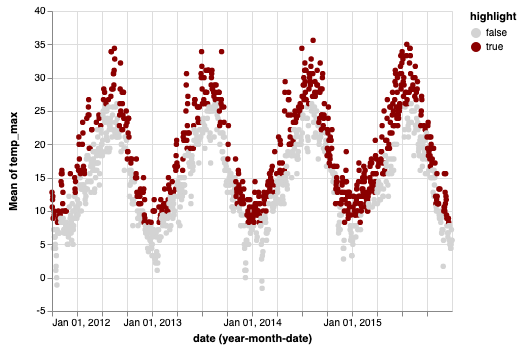

In [63]:
alt.Chart(weather).mark_circle().encode(
    x = 'yearmonthdate(date):T',
    y = 'mean(temp_max):Q',
    color = alt.Color('highlight:O', scale=alt.Scale(domain=['false', 'true'],
                      range=['lightgray', 'darkred']))
).transform_calculate(
    highlight = 'datum.temp_max > datum.monthly_mean'
)

## Weather table highlighting rain

The first key to creating a table in Altair is actually to destroy your table structure. Altair can't really display Pandas columns as separate columns in a visualization. What it can do is to place the unique entries in a single column across the X-axis of a text visualization. So, you need to `melt` your DataFrame such that your Y-axis data is still in it's own column (think of these as "row IDs"), and the rest of the data is pivoted (in Tableau terms) such that the column headers are in one column, and the data entries are in the third column.

The trick to highlighting certain whole rows is that the highlights are really a heatmap with only a single column. To create that, you need to filter out all of the other data "columns" (even though what you're really doing is filtering down to a certain rows in a categorical column), and then run a test for which of those remaining rows have the feature you want to highlight, and then coloring by the "true" values.

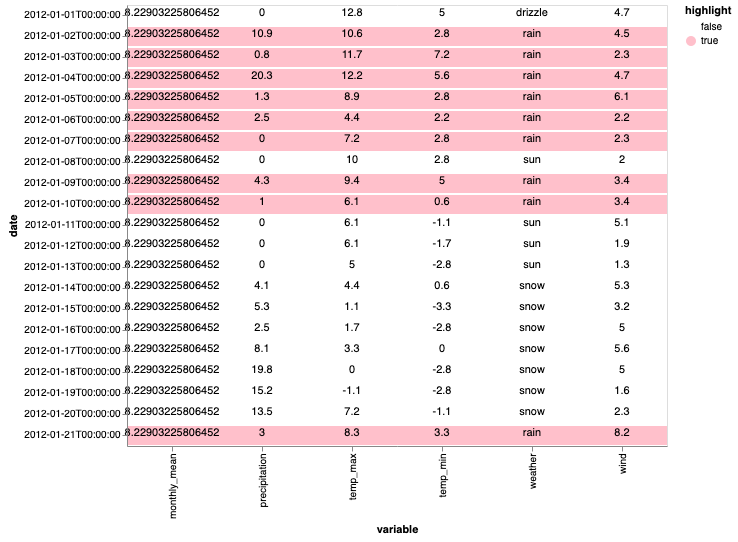

In [57]:
# Melt data to get it in a "tidy" form that Altair can handle
# You want it to have three columns in the end, Row ID, Column headers, table values

# Limit this to just a few rows or your table will be huge
# Remember it won't scroll!

w_tidy = weather.loc[:20].copy().melt(id_vars=['date'])

# Create the highlight rows heatmap for behind the text

rows_heatmap = alt.Chart(w_tidy).transform_filter(
    alt.datum.variable == "weather"
).transform_calculate(
    highlight = 'datum.value == "rain"'
).mark_rect().encode(
    y = 'date:O',
    color = alt.Color('highlight:O', scale=alt.Scale(domain=['false', 'true'],
                      range=['white', 'pink']))
)

# Now the text visualization for on top

text_table = alt.Chart(w_tidy).mark_text().encode(
    x = 'variable:N',
    y = 'date:O',
    text = 'value:N'
)

rows_heatmap + text_table

### Nature bar values data

Second example showing the same procedure for melting data and then creating a grid visualization of text with heatmap rows behind for highlight

In [5]:
df_orig = pd.read_csv('data/NatureBarValues.csv')
df = df_orig.melt(id_vars=["Item"],var_name="Category")
df.head(10)

,Item,Category,value
0,Item 1,Category 1,6
1,Item 2,Category 1,8
2,Item 3,Category 1,10
3,Item 4,Category 1,20
4,Item 5,Category 1,23
5,Item 1,Category 2,29
6,Item 2,Category 2,27
7,Item 3,Category 2,21
8,Item 4,Category 2,17
9,Item 5,Category 2,5


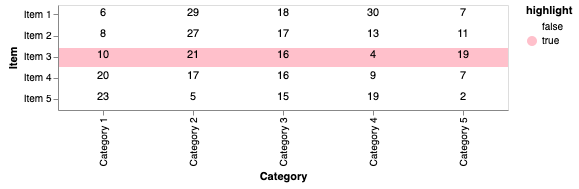

In [6]:
rows_heatmap = alt.Chart(df).transform_filter(
    alt.datum.Category == "Category 1"
).transform_calculate(
    highlight = 'datum.value == 10'
).mark_rect().encode(
    y = 'Item',
    color = alt.Color('highlight:O', scale=alt.Scale(domain=['false', 'true'],
                      range=['white', 'pink']))
)

text_table = alt.Chart(df).mark_text().encode(
    x = 'Category',
    y = 'Item',
    text = 'value'
)

rows_heatmap + text_table

## Pandas table visualization – alternative methods

### Provisional *style* functionality

Pandas has a provisional feature that they're developing to do "conditional formatting" to the display of Pandas tables.

[https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html]()

### DataFrame .to_html()

Pandas DataFrames have a built-in functionality of `.to_html()` that you can run

[https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_html.html]()

I think it should be possible to then use selectors, perhaps through 
[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/)
to alter the classes and display of the HTML.

### Plotly tables

The visualization library 
[Plotly has table functionality](https://plot.ly/python/table/) with a lot of display options.

### HTML to PDF in Python

There seem to be multiple modules that help you turn HTML and CSS into PDF from within Python

- [This article]() covers Xhtml2pdf, WeasyPrint, and Unoconv.
- At least one of the previous tools uses [Reportlab open source toolkit](https://www.reportlab.com/opensource/) behind the scenes, and I used it years ago to programmatically generate PDFs from Python.
- [pdfkit](https://pypi.org/project/pdfkit/) seems to be a viable module